# A Gentle start

In [1]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

In [29]:
%config InlineBackend.figure_format = "retina"

key = jax.random.PRNGKey(314)

In [3]:
def step(state, xs, update_fn):
    """
    At every timestep we compute the compute the
    predicted expert choice based on the still-credible
    experts. We then update the weights only if the aggregate
    prediction is the true prediction

    state: weights, n_errors
    xs: experts, y
    update_fn: Function to update the weights
    """
    weights, n_errors = state
    experts, y = xs
    
    expert_choice = (weights * experts).sum() / weights.sum()
    expert_choice = round(expert_choice) == y

    # Update the weights only if the forecast is erroneous
    weights, n_errors = jax.lax.cond(expert_choice,
        lambda *_: (weights, n_errors),
        update_fn,
        y, weights, experts, n_errors
    )

    out = {
        "weights": weights,
        "n_errors": n_errors,
    }

    new_state = (weights, n_errors) 
    return new_state, out

## Perfect expert

In this example, we assume that, given $E$ number of experts, there is one which predicts the oracle 100% of the times. At time $t=0$, we assign a weight of $1$ for each. We have $\forall e \in \{1,\ldots, E\}. \, w_{e, 0} = 1$.

A prediction at time $t$ is given by
$$
    \hat y_t = \mathbb{1}\left(\frac{\sum_{e=1}^E w_{e,t-1}f_{e,t-1}}{\sum_{e=1}^E w_{e,t-1}} \geq \frac{1}{2} \right),
$$

i.e., we predict $1$ if at least half of all *active* experts predicted $1$. If the forecast is incorrect, i.e., $\hat y_t \neq y_t$, we assign a weight of $0$ to all the experts who predicted incorrectly.


Let $N_m$ be the number of experts whose weight equals $1$ after $m$ number of mistakes, $W_m$ the number of *active* experts after the forecaster has made $m$ mistakes. At the $m$-th error, at least half of the experts that have been correct so far make their first misake, i.e., $W_m \leq W_{m-1} / 2$. This is because $\hat y_t$ makes a prediction listening to the majority (>50%) of the experts.

We have that
$$
\begin{aligned}
    W_m &\leq W_{m-1} / 2\\
    &\leq W_{m-2} / 2 ^2 \\
    &\ldots\\
    &\leq W_0 / 2 ^ m\\
    &= E / 2^m
\end{aligned}
$$

Since there exits at least one perfect expert, we have that 
$$
    1 \leq W_m \leq E / 2^m.
$$


Solving for $m$, we find that
$$
    m \leq \log_2(E),
$$

i.e., the total number of errors is bounded by $\log_2(E)$

### An empirical test

In [20]:
def update_weights(y, weights, experts, n_errors):
    """
    We filter where the choice of an expert aligns
    with the true value only if the expert has not already
    a mistake in the past
    """
    filter_experts = experts == y
    weights = filter_experts * weights
    return weights, n_errors + 1

In [55]:
key_oracle, key_experts = jax.random.split(key)
n_experts = 2 ** 5
n_timesteps = 100
true_expert_where = 10

oracle = jax.random.bernoulli(key_oracle, p=0.5, shape=(n_timesteps,))
experts = jax.random.bernoulli(key_experts, p=0.5, shape=(n_timesteps, n_experts))

# Insert the one true expert to the list of forecasters
experts = jnp.insert(experts, true_expert_where, oracle, axis=1)

In [56]:
w_init = jnp.ones(n_experts + 1)
state_init = (w_init, 0)
xs = (experts, oracle)

step_part = partial(step, update_fn=update_weights)
(w_last, n_errors), hist = jax.lax.scan(step_part, state_init, xs)
weights_hist = hist["weights"]

In [57]:
# Total number of errors
n_errors

Array(5, dtype=int32, weak_type=True)

In [58]:
# Theoretical upper bound
jnp.floor(jnp.log2(n_experts))

Array(5., dtype=float32)

#### Evolution of game

In [59]:
hist["n_errors"]

Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32, weak_type=True)

In [60]:
# Number of active experts
weights_hist.sum(axis=1)

Array([16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,  8.,  8.,
        8.,  8.,  8.,  4.,  4.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

## Imperfect expert

In this example, we assume that there exits an expert that is correct **most** of the times.

If a forecaster makes a mistake at time $t$, we discount each expert who was wrong by a dicsount factor $\beta\in(0,1)$, i.e., $\forall k. f_{k, t} \neq y_t$,
$$
    w_k \gets \beta w_k.
$$

At the time the forecaster makes its $m$-th mistake, the total weight of the forecaster is at most $W_{m-1} /2$ plus $\beta W_{m-1}$ assuming that all experts made a mistake.
 
$$
    W_m \leq W_{m-1} / 2 + \beta W_{m-1} /2
$$

In [62]:
def update_weights_beta(y, weights, experts, n_errors, beta):
    """
    We filter where the choice of an expert aligns
    with the true value only if the expert has not already
    a mistake in the past
    """
    filter_experts = experts != y # 0 - 1 ==> 1 - β
    weights = jnp.exp(filter_experts * jnp.log(beta)) * weights
    
    return weights, n_errors + 1

In [63]:
key = jax.random.PRNGKey(314)

key_oracle, key_experts, key_noise = jax.random.split(key, 3)

n_experts = 2 ** 6
n_timesteps = 5_000
true_expert_where = 10

beta = 0.9
oracle = jax.random.bernoulli(key_oracle, p=0.5, shape=(n_timesteps,))
experts = jax.random.bernoulli(key_experts, p=0.5, shape=(n_timesteps, n_experts))


p_mistake = 0.05
mistakes = jax.random.bernoulli(key_noise, p=p_mistake, shape=(n_timesteps,))
true_expert  = oracle ^ mistakes # Flip bit if mistake

# Insert the one true expert to the list of experts
experts = jnp.insert(experts, true_expert_where, true_expert, axis=1)

min_errors = (true_expert != oracle).cumsum()

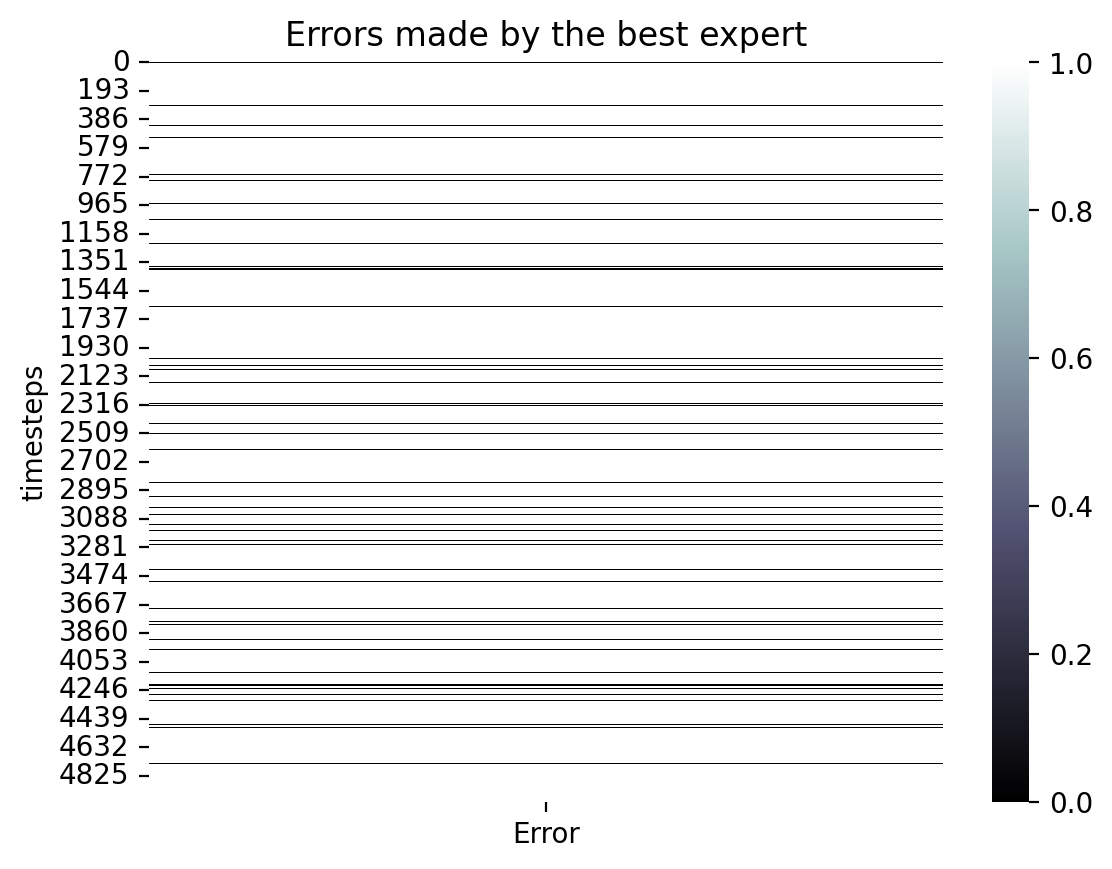

In [64]:
sns.heatmap(jnp.c_[oracle == true_expert], cmap="bone", xticklabels=["Error"])
plt.title("Errors made by the best expert")
plt.ylabel("timesteps");

In [65]:
w_init = jnp.ones(n_experts + 1)
state_init = (w_init, 0)
xs = (experts, oracle)

part_update_fn = partial(update_weights_beta, beta=beta)
step_part = partial(step, update_fn=part_update_fn)
(w_last, n_errors), hist = jax.lax.scan(step_part, state_init, xs)
weights_hist = hist["weights"]

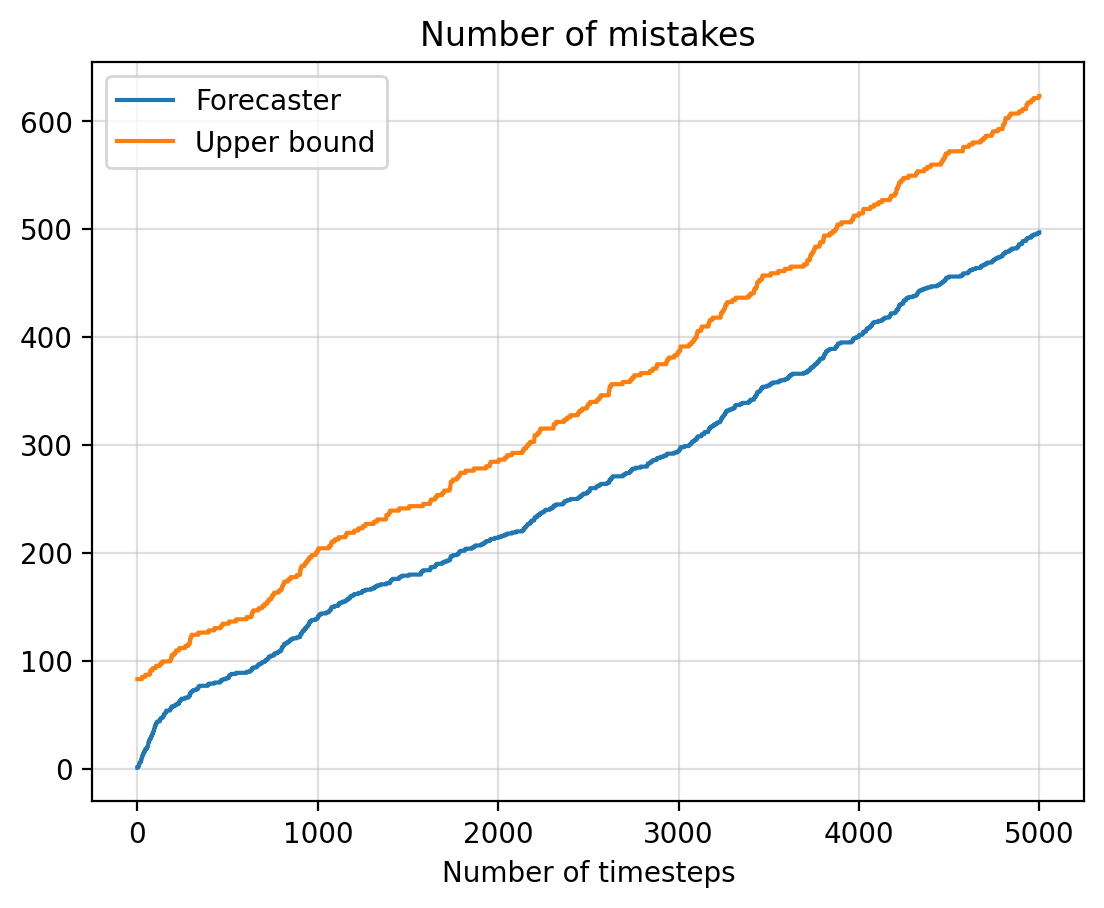

In [66]:
mistakes_ubound = (jnp.log2(n_experts) + min_errors * jnp.log2(1 / beta)) / (jnp.log2(2) - jnp.log2(1 + beta))

plt.plot(hist["n_errors"], label="Forecaster")
plt.plot(mistakes_ubound, label="Upper bound")
plt.legend()
plt.title("Number of mistakes")
plt.xlabel("Number of timesteps")
plt.grid(alpha=0.4)

### Multiple $\beta$-values

In [67]:
@partial(jax.vmap)
def vmap_eval_algo(beta):
    w_init = jnp.ones(n_experts + 1)
    state_init = (w_init, 0)
    xs = (experts, oracle)
    
    part_update_fn = partial(update_weights_beta, beta=beta)
    step_part = partial(step, update_fn=part_update_fn)
    (w_last, n_errors), hist = jax.lax.scan(step_part, state_init, xs)
    return hist["n_errors"]

In [68]:
n_betas = 30
beta_values = jnp.linspace(0.01, 1, n_betas)
hist_betas = vmap_eval_algo(beta_values)

cmap = plt.cm.RdBu_r
colors = cmap(jnp.linspace(0, 1, n_betas))

norm = mpl.colors.Normalize(vmin=min(beta_values), vmax=max(beta_values))
cmappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

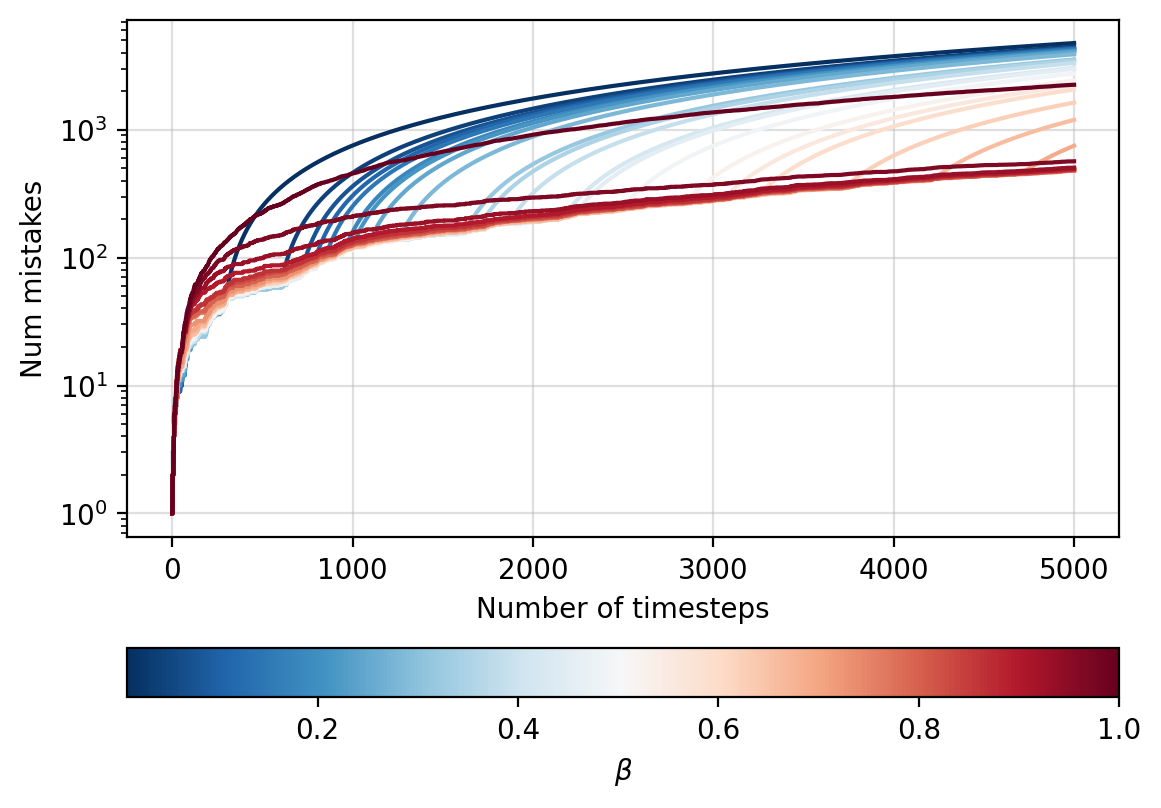

In [71]:
fig, ax = plt.subplots()
for hist, c in zip(hist_betas, colors):
    ax.plot(hist, c=c)

ax.set_yscale("log")
ax.set_ylabel("Num mistakes")
ax.set_xlabel("Number of timesteps")
fig.colorbar(cmappable, ax=ax, orientation="horizontal", label=r"$\beta$")
ax.grid(alpha=0.4)